# Pulse Arrival Analysis

In [2]:
import os
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from __future__ import (division, absolute_import, print_function)
from scipy import interpolate

from astropy import coordinates as coord
from astropy import units as u
from astropy import constants as const
from astropy import time as astrotime
from astropy.time import Time
from scipy.signal import find_peaks

from  matplotlib import pyplot as plt
import matplotlib

from math import pi

def deg2rads(dec_string):
    dec_array = dec_string.split(':')
    dec_rads = (np.abs(float(dec_array[0])) + float(dec_array[1])/60 +
                float(dec_array[2])/3600)*np.sign(float(dec_array[0]))*np.pi/180
    
    return dec_rads

def ha2rads(ra_string):
    ra_array = ra_string.split(':')
    ra_rads = (float(ra_array[0])*15 + float(ra_array[1])*0.25 + 
               float(ra_array[2])*0.004166)*np.pi/180
    
    return ra_rads

%matplotlib inline

font = {'family' : 'arial',
        'weight' : 'normal',
        'size'   : 20}
matplotlib.rc('font', **font)

# Errors are in milliseconds
pulsar_name = 'Crab3'

pulsar_ra = "05:34:31.93830"
pulsar_ra_error = 5

pulsar_dec = "22:00:52.1758"
pulsar_dec_error = 60

dec = deg2rads(pulsar_dec)
ra = ha2rads(pulsar_ra)

## 1. Reading Data

The ToAs are recorded as a time value in [Modified Julian Date](http://tycho.usno.navy.mil/mjd.html) (MJD). The error is recorded in microseconds.

The barytable has six columns: Firstly the year, month, day number, followed by x, y, z components of the vector in [astronomical units](https://en.wikipedia.org/wiki/Astronomical_unit). This table should be for the year your observations are recorded.

In [3]:
# Get the data directory path
current_dir = os.getcwd()
root_dir = os.path.abspath(os.path.join(current_dir, os.pardir))
data_dir = os.path.join(root_dir, "Data")

barytable_dir = os.path.join(data_dir, "BaryTables")
toa_dir = os.path.join(data_dir, "TOAs")
period_dir = os.path.join(data_dir, "PeriodEstimates")

save_data_dir = os.path.join(data_dir, "PeriodFitData")

# -----------------------------------------------------
# Functions for reading data
def load_barytable(file_name):
    """
    Load the barytable file.
    
    @param file_name :: name of the file containing barytable data
    
    @returns :: arrays with year, month, day, xpos, ypos, zpos
    """
    
    file_name = file_name + '.asc'
    data_file = os.path.join(barytable_dir, file_name)
    barytable = np.loadtxt(data_file, unpack=True)
    
    return barytable

def load_toas(file_name):
    """
    Load the time of arrivals from file.
    
    @param file_name :: name of the file containing barytable data
    
    @returns :: array containing time of arrival
    """
    
    file_name = file_name + '.asc'
    data_file = os.path.join(toa_dir, file_name)
    toas = np.loadtxt(data_file, usecols=(2,3))
    
    return toas
    
def read_pest(file_name):
    """
    Read the period estimate form file.
    
    @param file_name :: name of the file containing barytable data
    
    @returns :: float with the period estimate
    """
    
    file_name = file_name + '.asc'
    data_file = os.path.join(period_dir, file_name)
    with open(data_file) as dfile:
        line = dfile.read()
        
    period = float(line[23:-8])
    
    return period

## 2. Interpolation of Barycenter


In [4]:
def compose_date(years, months=1, days=1,
                 hours=None, minutes=None, seconds=None,
                 milliseconds=None):
    """
    Converts array of years, months etc. into numpy64 date array.
    
    @param years :: array of years corresponding to each date
    @param months :: array of months corresponding to each date
    @param days :: array of days corresponding to each date
    @param hours :: array of hours corresponding to each date
    @param minutes :: array of minutes corresponding to each date
    @param seconds :: array of seconds corresponding to each date
    
    @returns :: array of numpy64date format dates
    """
    
    years = np.asarray(years) - 1970
    months = np.asarray(months) - 1
    days = np.asarray(days) - 1
    types = ('<M8[Y]', '<m8[M]', '<m8[D]', '<m8[h]',
             '<m8[m]', '<m8[s]', '<m8[ms]')
    vals = (years, months, days, hours, minutes, seconds, milliseconds)
    return sum(np.asarray(v, dtype=t) for t, v in zip(types, vals)
               if v is not None)

def mjd_convert(raw_data):
    """
    Converts normal dates from psrchive to modified julian dates.
    
    @param raw_data :: raw array of year, month, day as read from
                       the data file on the barycentre
                       
    @returns :: modified julian date format times
    """
    
    dates = raw_data[:3]
    midnights = np.zeros((4,len(dates[0])))
    times_raw = np.concatenate((dates,midnights))
    times = compose_date(times_raw[0], times_raw[1], times_raw[2],
                         times_raw[3], times_raw[4], times_raw[5],
                         times_raw[6])
    converted_times =  Time(times.astype('string').tolist(), 
                            format='isot', scale='utc')
    mjd_times = converted_times.mjd
    
    return mjd_times

def bary_distance(raw_data):
    """
    Computes the distance from the barycenter to Earth
    on a particular day at a particular time.
    
    @param raw_data :: raw array of year, month, day as read from
                       the data file on the barycentre
                       
    @returns :: magnitude of the x,y,z vector from the raw data
    """
    
    xyz = np.transpose(raw_data[3:])
    dist = np.zeros(len(xyz))
    for i, vect in enumerate(xyz):
        dist[i] += np.sqrt(vect[0]**2 + vect[1]**2 + vect[2]**2)
    
    return dist

In [5]:
def lag_int(time, order):
    """
    Performs a lagrangian interpolate of order n
    to more accurately determine the Earth-Bary distance at
    a specific time.
    
    @param time :: desired time for which the distance should
                   be calculated
    @param order:: order of the lagrangian interpolate to be calculated
    
    @returns :: the interpolated coordinates and their associated errors
    """
    
    if order == 1:
        raise RuntimeError("Order cannot be 1! Interpolate 1 point? What?")
        
    idxs = np.where(np.logical_and(mjd_times <= time + order/2,
                                   mjd_times >= time - order/2))
    xvals = mjd_times[idxs]
    yvals = distances[idxs]
    coords, interp_errors = coord_interp(time, idxs, xvals)
    
    return coords, interp_errors

def coord_interp(time, idxs, xvals):
    """
    Performs a lagrangian interpolate of order n
    to more accurately determine the Earth-Bary coordinate
    at a specific time.
    
    @param time :: desired time for which the distance should
                   be calculated
    @param order :: order of the lagrangian interpolate to be calculated
    
    @returns :: the distance at the specified time and the error on it
    """
    
    coords = []
    coords_errors = []
    interp_errors = []
    for i in range(0, 3):
        yvals = []
        for j in range(idxs[0][0], idxs[0][-1] + 1):
            yvals.append(bary_coord[j][i])
        
        interp = interpolate.lagrange(xvals, yvals)

        coords.append(interp(time))
        interp_errors.append(residual(yvals))
    
    return coords, interp_errors

def residual(yvals):
    """
    Function that finds the delta in determining
    the residuals of the lagrange interpolation formula.
    
    @param yvals :: the Bary-Earth distances of the interpolated
                    points in the data
    
    @returns :: the error due to interpolation on the yvals data
    """
    
    order = len(yvals)
    coeff = [0.125, 0.065, 0.042, 0.031, 
             0.024, 0.019, 0.016]
    delta = yvals
    
    for i in range(0, order-1):        
        delta = np.diff(delta)

    error = coeff[order-2] * delta
    
    return error[0]

## 3. Delays

In [6]:
# Initialise some constants used throughout
# All these constants are in SI except where specified otherwise
pulsarpos = coord.SkyCoord(ra=pulsar_ra,
                           dec=pulsar_dec,
                           unit=(u.hourangle,u.deg))

lat = 53.2369*np.pi/180
lon = -2.3075*np.pi/180

lovellpos = coord.EarthLocation.from_geodetic(lat=53.2369, lon=-2.3075)
earth_radius = 6378100.
light_speed = 299792458.

### 3.1 Earth delay

In [7]:
def earth_delay(times, times_err):
    """
    Computes the earth delay in seconds for a set of ToAs.
    
    @param times :: array of ToAs in mjd
    @param times_err :: ToA errors in microseconds
    
    @returns :: the Earth delay in seconds
    """
    times = astrotime.Time(times, format='mjd')
    altaz = pulsarpos.transform_to(coord.AltAz(obstime=times,
                                               location=lovellpos))
    # Get radians altitude
    alt = coord.Angle(altaz.alt, u.radian)
    alt_error = altitude_error(times, times_err)
    
    earth_delay = earth_radius * np.sin(alt)/light_speed
    edelay_err = np.abs(earth_radius * np.cos(alt) * alt_error / light_speed)
    
    return earth_delay, edelay_err

def altitude_error(times, times_err):
    """
    Computes the errors on the altitudes based on the errors
    of the ToAs.
    
    @param times :: the ToAs in mjd
    @param times_err :: the error on the ToAs in microseconds
    
    @returns :: the error on the altitudes
    """
    altaz = pulsarpos.transform_to(coord.AltAz(obstime=times,
                                               location=lovellpos))
    alt = coord.Angle(altaz.alt, u.radian)
    az = coord.Angle(altaz.az, u.radian)
    
    # HA error in seconds
    ha = np.arcsin(-np.sin(az)*np.cos(alt)/np.cos(dec))
    ha_error = np.sqrt(np.power(times_err * 0.001, 2) + pulsar_ra_error**2)*np.pi*0.001/(3600*12)
    
    # Error propagation for altitude error
    alt_error = np.sqrt( (((-np.cos(ha)*np.cos(lat)*np.sin(dec) + 
                            np.cos(dec)*np.sin(lat))/
                            np.sqrt(1 - (np.cos(dec)*np.cos(ha)*np.cos(lat) + 
                                         np.sin(dec)*np.sin(lat))**2))**2)*
                            ((pulsar_dec_error*0.001*np.pi/(3600*180))**2) +
                         ((np.cos(dec)*np.cos(lat)*np.sin(ha)/
                           np.sqrt(1-(np.cos(dec)*np.cos(ha)*np.cos(lat) + 
                                      np.sin(dec)*np.sin(lat))**2))**2)*
                           (ha_error**2)
                       )
    return alt_error

### 3.2 Barycentre Delay

In [8]:
def psr_unit_error(psr_unit):
    """
    Calculates the error on the unit vector
    pointing from barycentre to the pulsar.
    
    @parma psr_unit :: pulsar unit vector array (unitless)
    
    @returns :: the pulsar unit vector error unitless
    """
    
    x = psr_unit[0]
    y = psr_unit[1]
    z = psr_unit[2]
    
    dec_err = (pulsar_dec_error*0.001/3600)*np.pi/180
    ra_err = (pulsar_ra_error*0.001/3600)*np.pi/12
    
    x_err = np.sqrt( ((np.sin(dec)*np.cos(ra))**2)*(dec_err*2) + 
                     ((np.cos(dec)*np.sin(ra))**2)*(ra_err**2) )
    y_err = np.sqrt( ((np.sin(dec)*np.sin(ra))**2)*(dec_err**2) + 
                     ((np.cos(dec)*np.cos(ra))**2)*(ra_err**2) )
    z_err = np.sqrt( (np.cos(dec)**2)*(dec_err**2) )
    
    return np.array([x_err, y_err, z_err])

def bary_delay_error(psr_unit, psr_unit_error, coords, interp_error):
    """
    Order of magnitude estimate of the errors on the barycenter delay.
    
    @param psr_unit_error :: error on the unit vector pointing to the pulsar
    @param interp_errors :: interpolation error for barycenter position
    
    @return :: order of magnitude approximation of the delay error
    """
    
    delay_error = np.sqrt( (coords[0]**2)*(psr_unit_error[0]**2) +
                           (coords[1]**2)*(psr_unit_error[1]**2) +
                           (coords[2]**2)*(psr_unit_error[2]**2) +
                           (psr_unit[0]**2)*(interp_error[0]**2) +
                           (psr_unit[1]**2)*(interp_error[1]**2) +
                           (psr_unit[2]**2)*(interp_error[2]**2) )/light_speed
    
    return delay_error

def bary_delay(times):
    """
    Calculates the delay from the center of the Earth to the
    barycenter.
    
    @param time :: time of pulse arrival
    @param time_errors :: error on the times
    
    @returns :: the delay from center of Earth to Barycenter
                and the delay error (order of magnitude approx)
    """
    # AU per sec light speed
    light_speed = 0.00200399
    
    pulsarpos = coord.SkyCoord(ra="05:34:31.93830",
                               dec="22:00:52.1758", 
                               unit=(u.hourangle,u.deg))
    pulsarpos.representation = 'cartesian'
    psr_unit = np.array([pulsarpos.x, pulsarpos.y, pulsarpos.z])
    psr_unit_err = psr_unit_error(psr_unit)
    
    delays = []
    delays_errors = []
    
    for i,time in enumerate(times):
        coords, interp_error = lag_int(time, 3)
        delay = np.dot(coords, psr_unit)/light_speed
        delay_error = bary_delay_error(psr_unit, psr_unit_err, 
                                       coords, interp_error)
        
        delays.append(delay)
        delays_errors.append(delay_error)

    return delays, delays_errors

## 4. Period Calculation

In [9]:
def get_remainders(times, times_errors, period, pulsar, fileit):
    """
    Function calculates the number of rotations of the star
    
    @param times :: ToAs determined from the file in mjd
    @param period :: initial guess for the period of Crab pulsar in seconds
    @param crab :: which crab observations you are doing the analysis
                   for, e.g. crab1, crab2 etc.
    
    @return :: saves the remainders of the division between the ToA and
               the time of arrival for every pulse
               also outputs times and corresponding remainders
               and their errors
    """
    
    sec_times = times * 86400
    remainders = sec_times % period
    remainders_errors = times_errors
    
    if fileit == 'y':
        file_data(sec_times, pulsar + "_times.txt")
        file_data(remainders, pulsar + "_remainders.txt")
        file_data(remainders_errors, pulsar + "_errors.txt")
    
    return times, remainders, remainders_errors

def file_data(data, filename):
    """
    Function that writes some data to a file, all in a row.
    
    @param data :: 1D array to be saved to file
    @param filename :: the name of the file the data is saved to
    
    @returns :: the written file    
    """
    
    crab_file = os.path.join(save_data_dir, filename)
    with open(crab_file, 'w') as f:
        for elem in data:
            f.write(str(elem) + ' ')

## 4. Analysis

### 4.1 Import data

In [10]:
# Crab 1 data
barytable = load_barytable('Crab1Barytable')
toas = load_toas(pulsar_name + 'ToAs')
pest = read_pest(pulsar_name + 'TEst')

In [11]:
# Calculate mjd times and distances Earth-Bary
# it does not matter what barytable one chooses
# they are all the same

mjd_times = mjd_convert(barytable)
distances = bary_distance(barytable)
bary_coord = np.transpose(barytable[3:])


### 4.2 Compute the Delays

In [12]:
# First crab observation times
edelays, edelays_errors = earth_delay(toas[:,0], toas[:,1])
bdelays, bdelays_errors = bary_delay(toas[:,0])


bary_time = toas[:,0] + (bdelays + edelays)/86400
btime_errors = np.sqrt(np.power(toas[:, 1] * 10**(-6), 2) + 
                       np.power(edelays_errors, 2) +
                       np.power(bdelays_errors, 2))

### 4.3 Remainder Analysis

0.0337557872


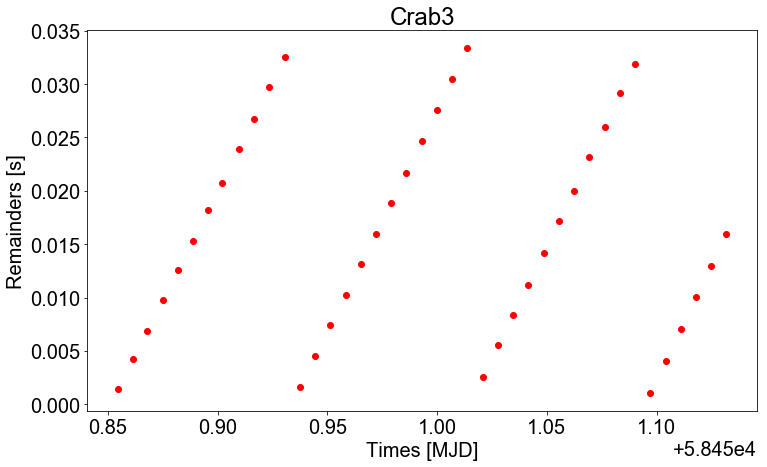

In [21]:
# Get times and remainders for first crab observation
# Fitting and the rest of analysis is done in mathematica
period_guess = pest
times_init, remainders_init, remainders_errors_init = \
get_remainders(bary_time, btime_errors, period_guess, pulsar_name, 'y')

print(period_guess)
plt.figure(figsize=(12,7))
plt.errorbar(times_init, remainders_init, yerr = remainders_errors_init, fmt = 'ro')
plt.xlabel('Times [MJD]')
plt.ylabel('Remainders [s]')
plt.title(pulsar_name)
plt.show()

In [14]:
# Crab 1 true period residual plots
true_period_file = save_data_dir + os.sep + pulsar_name + "_period.txt"
true_period, true_period_error = np.loadtxt(true_period_file)

# Alternative period by putting them back to back
true_periodalt_file = save_data_dir + os.sep + pulsar_name + "_periodalt.txt"
true_periodalt, true_periodalt_error = np.loadtxt(true_periodalt_file)

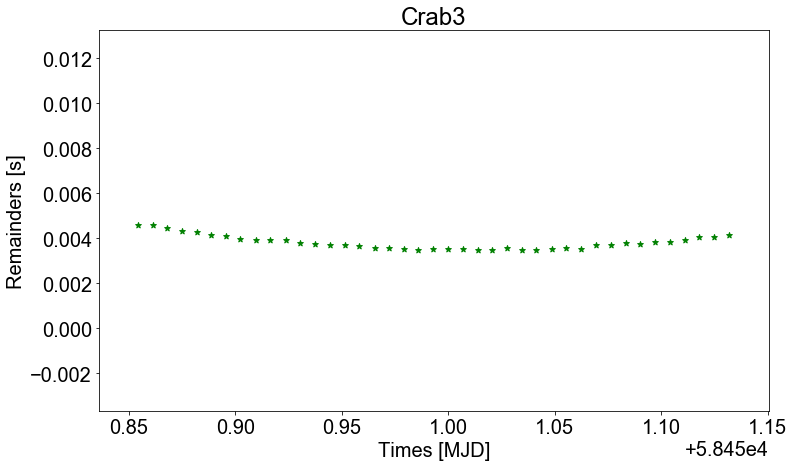

In [19]:
# Replotting the remainders with the true period
times_final, remainders_final, remainders_errors_final = \
get_remainders(bary_time, btime_errors, true_period, pulsar_name, 'n')


plt.figure(figsize=(12,7))
plt.scatter(times_final, remainders_final,c='g', marker='*')
plt.xlabel('Times [MJD]')
plt.ylabel('Remainders [s]')
plt.title(pulsar_name)
plt.show()

[58450.98581931]


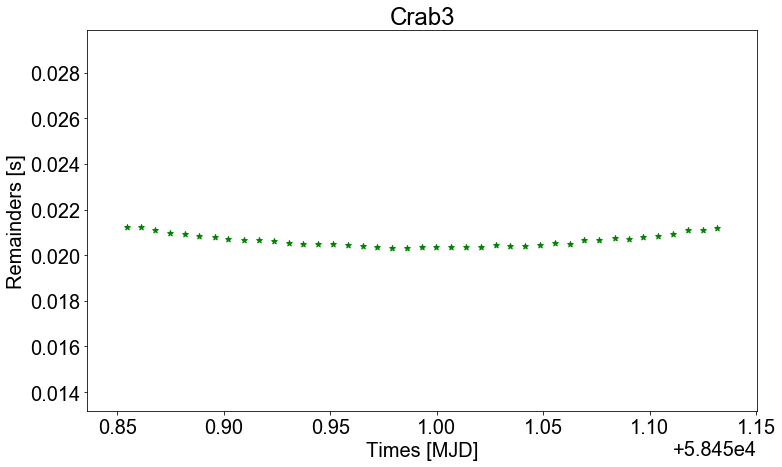

In [20]:
# Replotting the remainders with the alt method true period
# obtained through aligning the points
times_finalalt, remainders_finalalt, remainders_errors_finalalt = \
get_remainders(bary_time, btime_errors, true_periodalt, pulsar_name, 'n')

print(times_final[np.where(remainders_finalalt == np.amin(remainders_finalalt))])

plt.figure(figsize=(12,7))
plt.scatter(times_finalalt, remainders_finalalt,c='g', marker='*')
plt.xlabel('Times [MJD]')
plt.ylabel('Remainders [s]')
plt.title(pulsar_name)
plt.show()

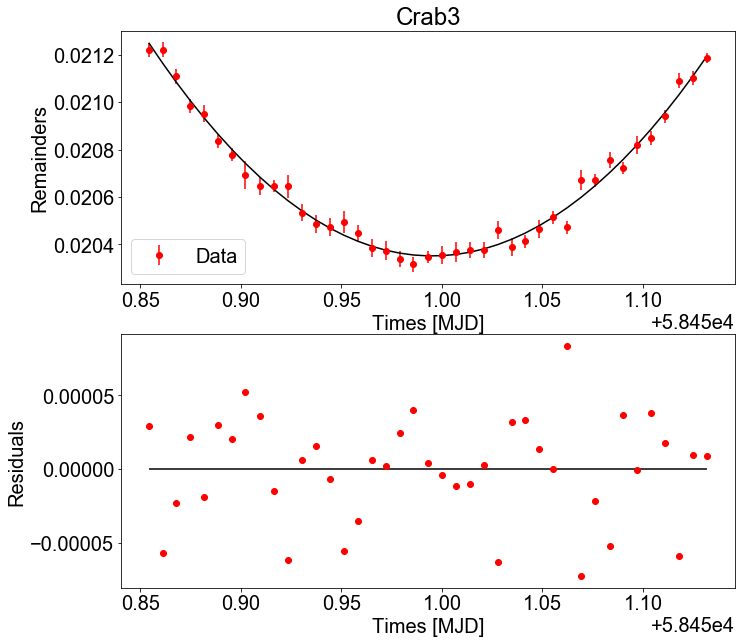

[ 4.52282212e-02 -5.28726909e+03  1.54523070e+08]
4.696722243185976e-08


In [17]:
# polyfit
[coef, cov] = np.polyfit(times_finalalt, remainders_finalalt, 2, cov=True)
functional_form = np.poly1d(coef)
best_fit = functional_form(times_finalalt)
err_pdot = np.sqrt(cov[0][0])

# plots the main figure
plt.figure(figsize=(11,9))
plt.subplot(211)
plt.errorbar(times_finalalt, remainders_finalalt, yerr=remainders_errors_finalalt, fmt='ro', \
             label='Data')
plt.plot(times_finalalt, best_fit, 'k-')
plt.xlabel('Times [MJD]')
plt.ylabel('Remainders')
plt.title(pulsar_name)
plt.legend()

# and the residuals
plt.subplot(212)
plt.plot(times_finalalt, best_fit-remainders_finalalt, 'ro')
plt.hlines(0, times_finalalt[0], times_finalalt[-1], colors='k')
plt.xlabel('Times [MJD]')
plt.ylabel('Residuals')

plt.subplots_adjust(bottom=0.02)
plt.show()

print(coef)
print(err_pdot)

4.01922548145e-13


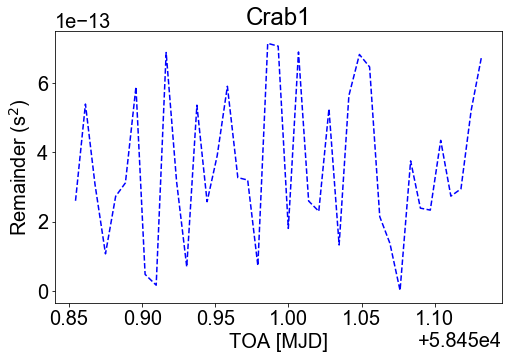

In [18]:
def cal_pdot(m, true_guess):
    return true_guess/(1+m)

pdot = cal_pdot(4.74654929e-02, 4.21e-13)
print(pdot)

res_new = (times_finalalt**2)%(2*pdot)

plt.figure(figsize=(8,5))
plt.plot(times_finalalt, res_new, 'b--')
plt.xlabel('TOA [MJD]')
plt.ylabel(r'Remainder (s$^2$)')
plt.title('Crab1')
plt.show()